In [7]:
import sys
sys.path.append("../")
import matplotlib.pyplot as plt

In [8]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch

In [9]:
! export PYTORCH_ENABLE_MPS_FALLBACK=1

In [10]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

In [11]:
mps_device = torch.device("mps")
torch.set_default_device(mps_device)

# Format input data

In [6]:
patient = 'R310'
PATH = "../../Data/echidna3/"
path = os.path.join(PATH, patient + "_tumors.h5ad")
print(path)

../../Data/echidna3/R310_tumors.h5ad


In [7]:
w_path = os.path.join(PATH, "all_cellranger_w.csv")
w_path

'../../Data/echidna3/all_cellranger_w.csv'

In [12]:
from echidna.utils import *

/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
W = read_W("../all_cellranger_w.csv")

In [14]:
X = sc.read_h5ad("../R310_postprocessed.h5")
X

AnnData object with n_obs × n_vars = 21640 × 25349
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rp', 'sample', 'patient', 'condition', 'barcode_orig', 'barcode_pat', 'samples_per_patient', 'timepoint', 'Before.During.After', 'Sample_J', 'Gender', 'Treatment_phase', 'Drug', 'tissue', 'Mutation', 'sample_group', 'predicted_doublets', 'doublet_scores', 'RNA_snn_res.0.8', 'seurat_clusters', 'clonotype_id', 'chain', 'v_gene', 'd_gene', 'j_gene', 'c_gene', 'frequency', 'proportion', 'cdr3s_aa', 'cdr3s_nt', 'inkt_evidence', 'mait_evidence', 'tcr', 'mait', 'inkt', 'both_chains', 'clone_size', 'mait_inkt', 'celltype_bped_main', 'celltype_bped_fine', 'celltype_hpca_main', 'celltype_hpca_fine', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_origi

In [17]:
sc.tl.leiden(X, resolution=0.5)
cluster_counts = X.obs['leiden'].value_counts()
threshold = 20
small_clusters = cluster_counts[cluster_counts <= threshold].index.tolist()
X = X[~X.obs['leiden'].isin(small_clusters)].copy()
sc.pp.neighbors(X)
sc.tl.leiden(X, resolution=0.5)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


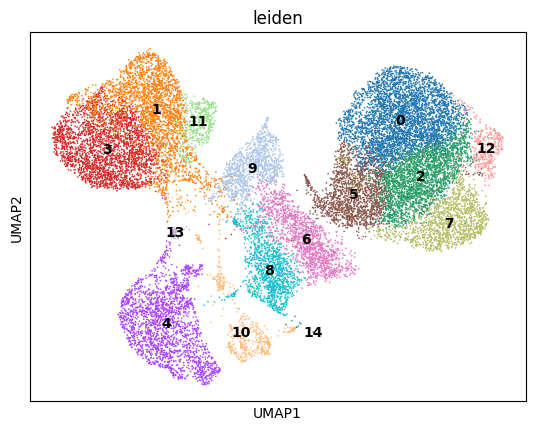

In [18]:
sc.pl.umap(X, color=['leiden'], legend_loc='on data')

In [26]:
(X_obs, W_obs, z_obs, pi_obs), (X_val, W_val, z_val, pi_val) = prepare_input(X, W, sample_name=patient, 
                                            timepoints=['on2', 'pre'], device="cpu")
print(X_obs.shape)
print(W_obs.shape)
print(z_obs.shape)
print(pi_obs.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.Size([2, 9307, 14375])
torch.Size([2, 14375])
torch.Size([2, 9307])
torch.Size([2, 15])


# Train model

In [13]:
from echidna.model import Echidna
from echidna.train import train_Echidna
from echidna.utils import ModelConfig
from echidna.eval import get_learned_params

In [14]:
config = ModelConfig()
config.num_cells = X_obs.shape[1]
config.num_genes = X_obs.shape[-1]
config.num_timepoints = X_obs.shape[0]
config.num_clusters = pi_obs.shape[-1]
config.q_corr_init = 1e-2
config.q_shape_rate_scaler = 10.0
config.eta_mean_init = 2.0
config.cov_prior = 'mvn'
config.eps = 5e-3

In [31]:
echidna = Echidna(config, mode="MT", device="cpu")

In [32]:
echidna, loss = train_Echidna(echidna, X_obs, W_obs, pi_obs, z_obs, lr=0.001, n_epochs=1000)

100%|██████████| 1000/1000 [08:16<00:00,  2.02it/s]


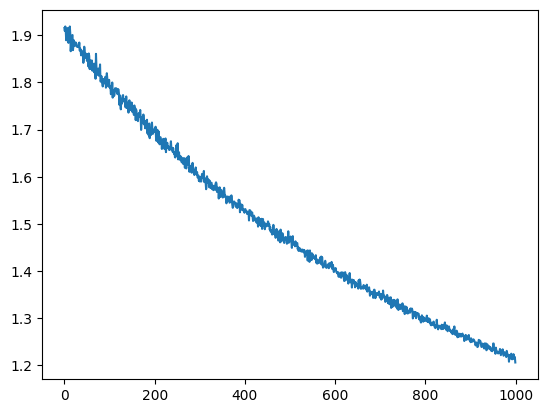

In [33]:
plt.plot(loss)

In [34]:
params = get_learned_params(echidna, X_obs, W_obs, pi_obs, z_obs)

# Look at trained model

In [35]:
import torch.nn.functional as F
from echidna.eval import sample_W, sample_X, plot_true_vs_pred, sample_C
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
params.keys()

odict_keys(['_INPUT', 'G:genes', 'K:clusters', 'scale', 'cholesky_corr', 'eta', 'genes', 'timepoints_w', 'W', 'timepoints_c', 'c', 'X_0', 'X_1', '_RETURN'])

In [37]:
eta = F.softplus(params['eta']['value'].T)
c_on = params['c']['value'][0, :, :]
c_pre = params['c']['value'][1, :, :]
c_shape = pyro.param('c_shape')
lib_on = X_obs[0, :, :].sum(-1, keepdim=True) * 1e-5
lib_pre = X_obs[1, :, :].sum(-1, keepdim=True) * 1e-5
z_on = z_obs[0, :]
z_pre = z_obs[1, :]

In [38]:
X_learned_on = sample_X(X_obs.numpy(), c_on, eta, z_on.numpy(), lib_on)
X_learned_pre = sample_X(X_obs.numpy(), c_pre, eta, z_pre.numpy(), lib_on)

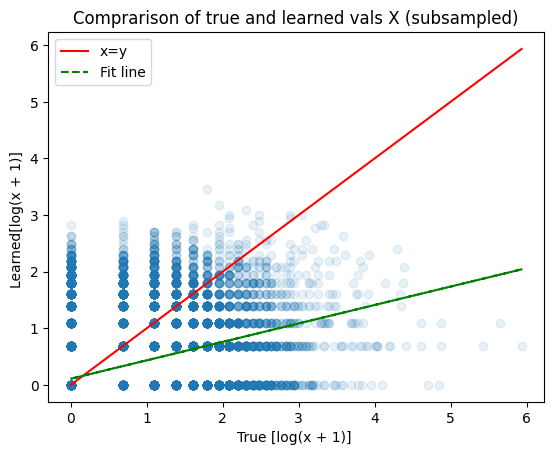

In [39]:
plot_true_vs_pred(X_learned_on, X_obs[0, :, :].numpy(), log_scale=True, name='X')

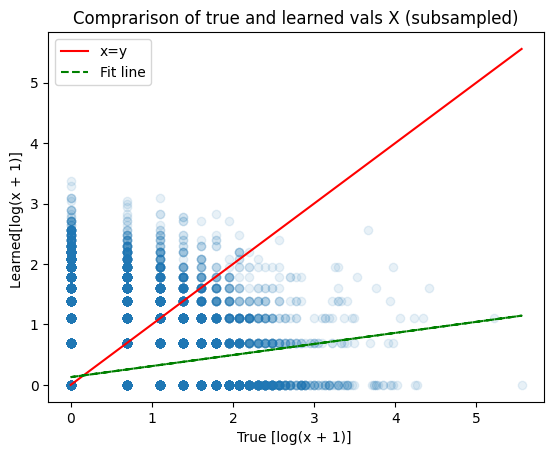

In [40]:
plot_true_vs_pred(X_learned_pre, X_obs[-1, :, :].numpy(), log_scale=True, name='X')

In [41]:
W_learned = np.array(sample_W(pi_obs, eta))
W_obs_np = W_obs.numpy()

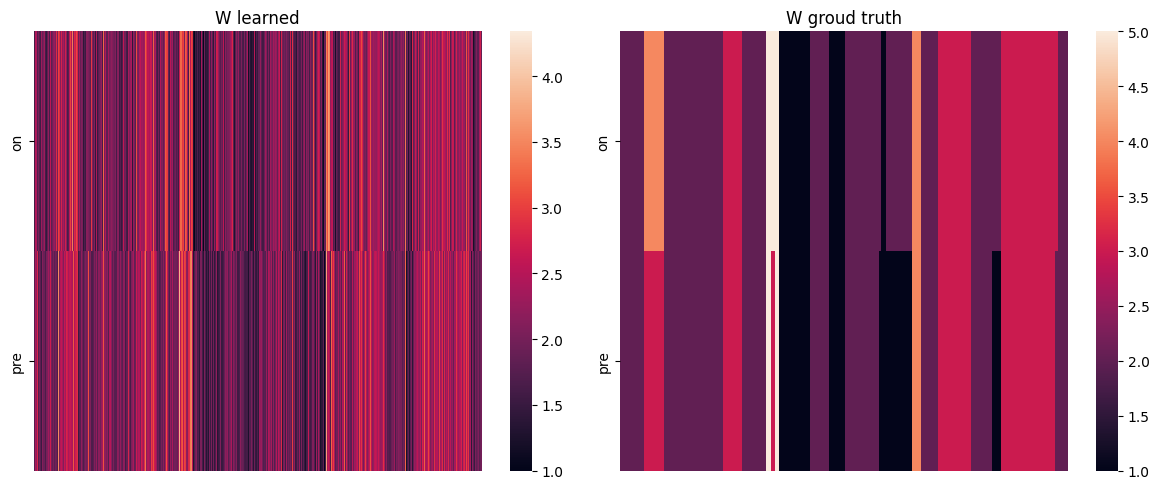

In [42]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first heatmap
sns.heatmap(W_learned, ax=axes[0], vmin=1)
axes[0].set_title('W learned')
axes[0].set_xticks([])
axes[0].set_yticklabels(['on', 'pre'])

# Plot the second heatmap
sns.heatmap(W_obs_np, ax=axes[1])
axes[1].set_title("W groud truth")
axes[1].set_xticks([])
axes[1].set_yticklabels(['on', 'pre'])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 100x100 with 0 Axes>

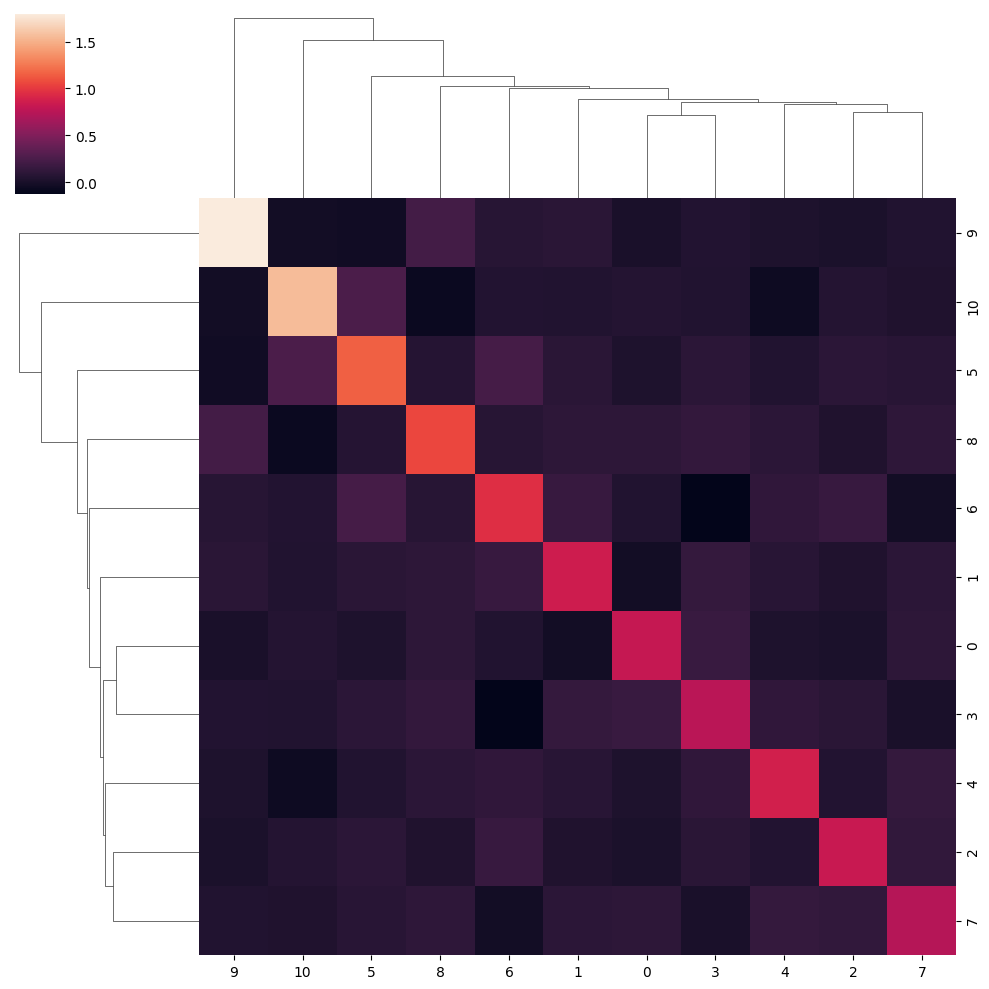

In [43]:
plt.figure(figsize=(1, 1)) 
sns.clustermap(torch.cov(eta).cpu().detach().numpy())
plt.show()

In [44]:
from echidna.eval import eta_cov_tree, assign_clones, learned_cov

In [45]:
params.keys()

odict_keys(['_INPUT', 'G:genes', 'K:clusters', 'scale', 'cholesky_corr', 'eta', 'genes', 'timepoints_w', 'W', 'timepoints_c', 'c', 'X_0', 'X_1', '_RETURN'])

In [46]:
L = params['cholesky_corr']['value']
scale = params['scale']['value']

In [47]:
cov = learned_cov(L, scale)

/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


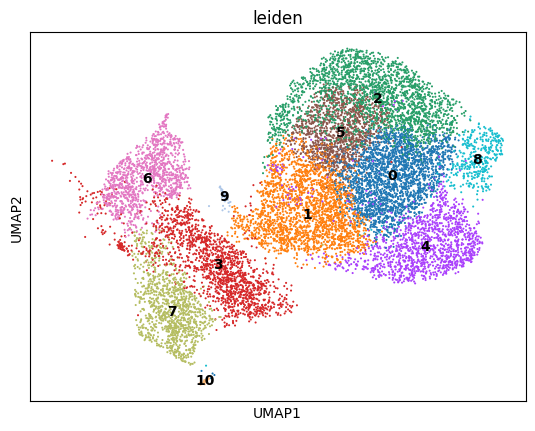

In [48]:
sc.pl.umap(X, color=['leiden'], legend_loc='on data')

In [49]:
from echidna.eval import eta_cov_tree_elbow_thresholding, eta_cov_tree

Knee point:  8
Threshold:  1.3624371217098734


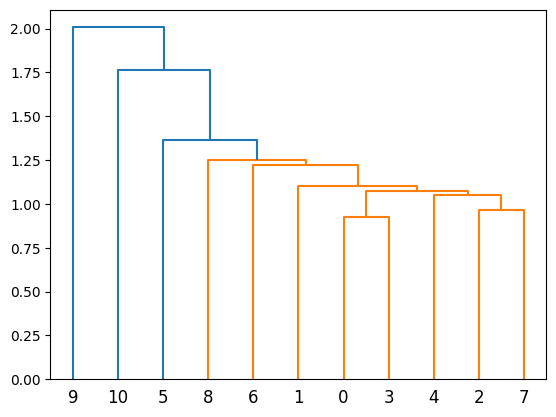

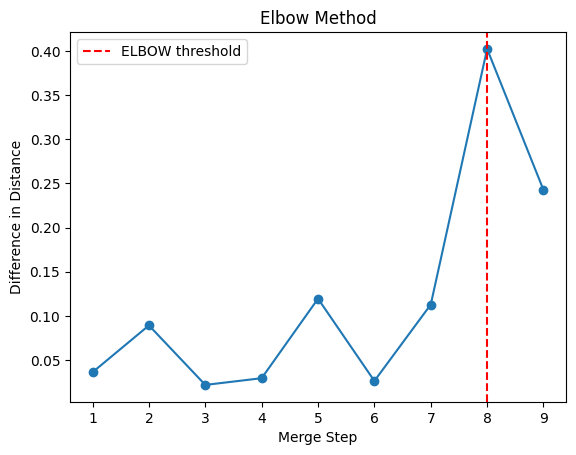

In [50]:
dn = eta_cov_tree_elbow_thresholding(eta, plot_elbow=True)

In [51]:
assign_clones(dn, X)

/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


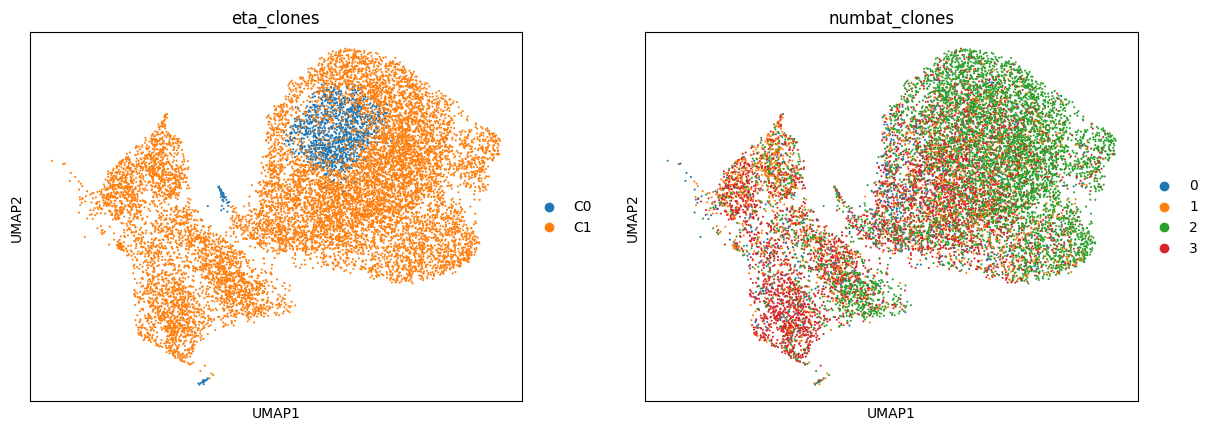

In [52]:
sc.pl.umap(X, color=['eta_clones', 'numbat_clones'])

In [46]:
c_pre.shape

torch.Size([11, 23648])

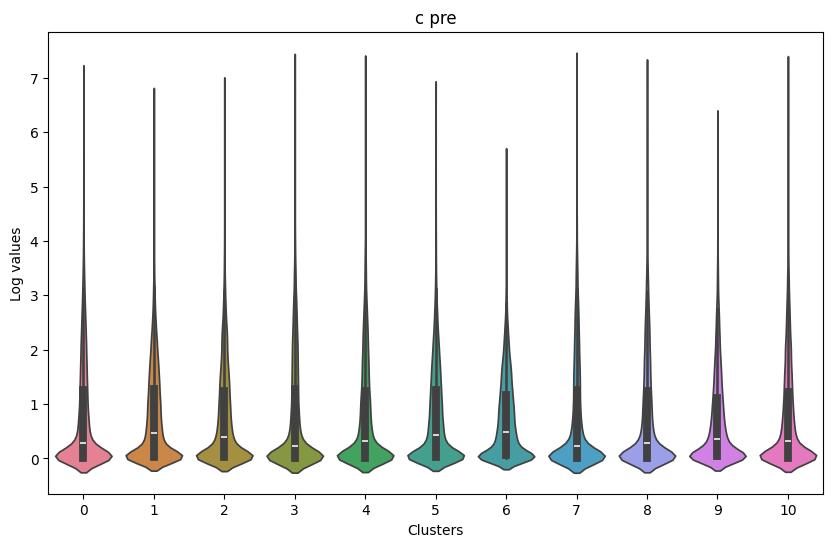

In [47]:
c_pre = torch.log1p(c_pre)
numpy_array = c_pre.detach().numpy().T

# Create a DataFrame for seaborn
import pandas as pd
df = pd.DataFrame(numpy_array)

# Plot violin plots using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=df)
plt.title('c pre')
plt.xlabel('Clusters')
plt.ylabel('Log values')
plt.show()

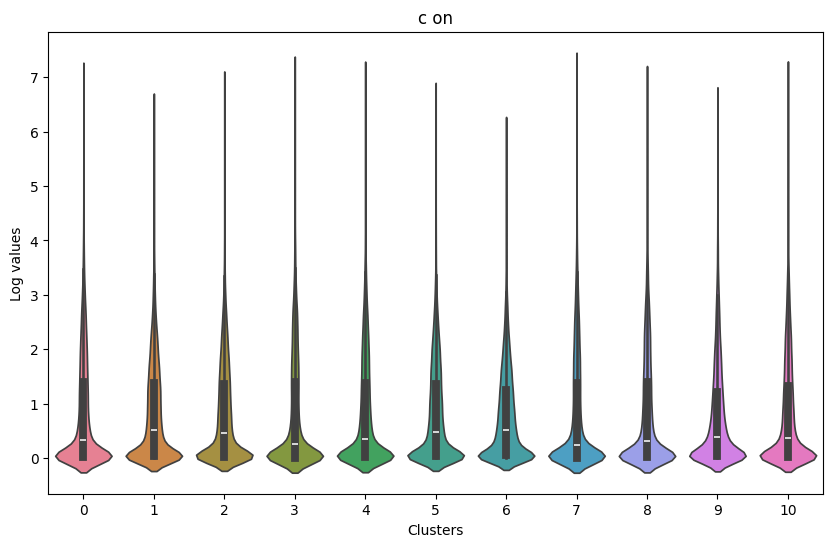

In [48]:
c_on = torch.log1p(c_on)
numpy_array = c_on.detach().numpy().T

# Create a DataFrame for seaborn
import pandas as pd
df = pd.DataFrame(numpy_array)

# Plot violin plots using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=df)
plt.title('c on')
plt.xlabel('Clusters')
plt.ylabel('Log values')
plt.show()

In [49]:
c_pre_sample = sample_C(c_shape, c_rate=eta, num_clusters=11, num_timepoints=2, target_dim=9, target_timepoint=1)
c_pre_sample.shape

torch.Size([1000, 23648])

In [50]:
c_on_sample = sample_C(c_shape, c_rate=eta, num_clusters=11, num_timepoints=2, target_dim=6, target_timepoint=0)
c_on_sample.shape

torch.Size([1000, 23648])

In [51]:
c_pre_mean = torch.mean(c_pre_sample, dim=0)
c_pre_mean.shape

torch.Size([23648])

In [52]:
c_on_mean = torch.mean(c_on_sample, dim=0)
c_on_mean.shape

torch.Size([23648])

In [53]:
c_pre_on = torch.stack([c_pre_mean, c_on_mean], dim=0)
c_pre_on.shape

torch.Size([2, 23648])

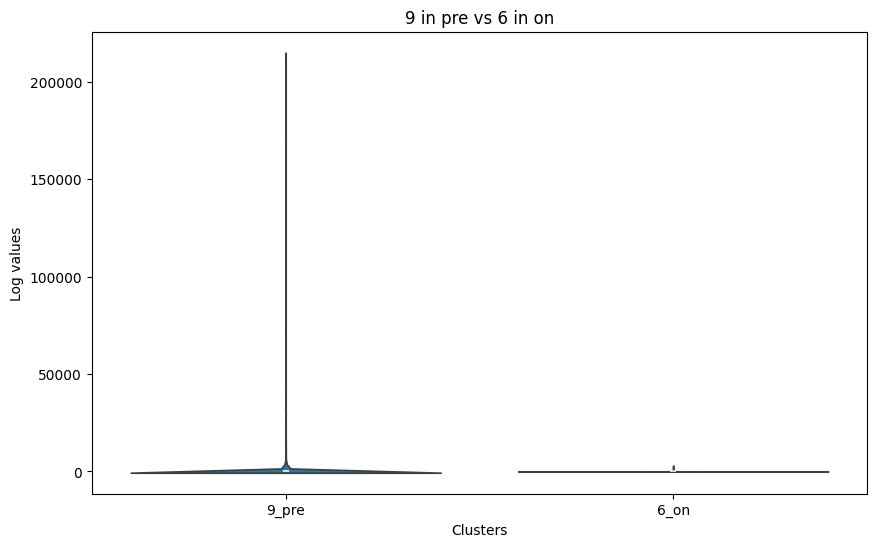

In [54]:
numpy_array = c_pre_on.numpy().T

# Create a DataFrame for seaborn
import pandas as pd
df = pd.DataFrame(numpy_array)

# Plot violin plots using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=df)
plt.title('9 in pre vs 6 in on')
plt.xlabel('Clusters')
plt.xticks(range(numpy_array.shape[1]), ['9_pre', '6_on'])
plt.ylabel('Log values')
plt.show()